# Supplement Figure --- lag time in river contribution

In [1]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
from dateutil.relativedelta import relativedelta
import netCDF4 as nc
from itertools import compress
import datetime as dt
from scipy.signal import find_peaks
from matplotlib.ticker import FormatStrFormatter, MultipleLocator
import matplotlib.dates as mdates
import xarray as xr
import os
from datetime import date
import seaborn as sns

%matplotlib inline

#### Parameters:

In [2]:
# domain dimensions:
imin, imax = 1479, 2179
jmin, jmax = 159, 799
isize = imax-imin
jsize = jmax-jmin

# model result set:
folder_ref  = '/data/brogalla/run_storage/Mn-reference-202110/'
folder_glac = '/data/brogalla/run_storage/river-glacial-202112/'
folder_cont = '/data/brogalla/run_storage/river-continental-202112/'

# Colors:
color_glac_dark = '#05507d'
color_glac      = '#0873b4'
color_cont_dark = '#995224'
color_cont      = '#a36339'
color_seas_dark = '#4c4c4c'
color_seas      = '#999999'

# List of years to look at:
years = [2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, \
         2016, 2017, 2018, 2019]

#### Load files:

In [3]:
# ANHA12 grid:
mesh       = nc.Dataset('/ocean/brogalla/GEOTRACES/data/ANHA12/ANHA12_mesh1.nc')
tmask      = np.array(mesh.variables['tmask'])[0,:,imin:imax,jmin:jmax]
land_mask  = np.ma.masked_where((tmask[:,:,:] > 0.1), tmask[:,:,:]) 
lons       = np.array(mesh.variables['nav_lon'])
lats       = np.array(mesh.variables['nav_lat'])
depths     = np.array(mesh.variables['gdept_1d'])[0,:]
e1t_base   = np.array(mesh.variables['e1t'])[0,imin:imax,jmin:jmax]
e2t_base   = np.array(mesh.variables['e2t'])[0,imin:imax,jmin:jmax]
e3t        = np.array(mesh.variables['e3t_0'])[0,:,imin:imax,jmin:jmax]
e3t_masked = np.ma.masked_where((tmask[:,:,:] < 0.1), e3t)

In [4]:
# Mn model grid:
ref   = nc.Dataset('/data/brogalla/run_storage/Mn-reference-202110/ANHA12_ref-2003_20211012/ANHA12_EXH006_2003_monthly.nc',  'r')
tlons = np.array(ref.variables['nav_lon'])
tlats = np.array(ref.variables['nav_lat'])
depth = np.array(ref.variables['deptht'])

In [5]:
# Load runoff forcing:
rf = np.empty((19*12, isize, jsize))
for i, year in enumerate(range(2002, 2020)):
    for month in range(0,12):
        file = f'/data/brogalla/runoff/ANHA12_runoff_monthly_combined_Dai_Trenberth_Bamber_y{year}.nc'
        with xr.open_dataset(file, decode_times=False) as c:
            rf[i*12+month,:,:] = c['runoff'].values[month,imin:imax,jmin:jmax]

In [6]:
# River classification file:
rclass = nc.Dataset('/ocean/brogalla/GEOTRACES/data/river_class-202005.nc','r')
river_class = rclass.variables['rclass']
river_class = np.array(river_class)

#### Functions:

In [7]:
def time_series_pickle(experiment, year):
    folder = '/ocean/brogalla/GEOTRACES/time-series/'
    
    # --- Coordinates of boundaries ---
    # Parry Channel western XS -- 2
    # Parry Channel eastern XS -- 11
    # Baffin Bay XS            -- 8
    # Nares Strait northern XS -- 7
    # Nares Strait southern XS -- 10
    
    # Load calculated time series of fluxes:
    time_series_V1, time_series_V2, time_series_V3, time_series_V4, time_series_V5, time_series_V6,time_series_V7,\
    time_series_V8, time_series_V9, time_series_V10, time_series_V11, time_series_mn1, time_series_mn2, \
    time_series_mn3, time_series_mn4, time_series_mn5, time_series_mn6, time_series_mn7, time_series_mn8, \
    time_series_mn9, time_series_mn10, time_series_mn11 = \
        pickle.load(open(f'{folder}{experiment}/time-series-{year}.pickle','rb'))  

    # convert mn from mol m3/L s --> mol /s by multiplying by 1e3
    return time_series_mn2*1e3, time_series_mn11*1e3, time_series_mn8*1e3, time_series_mn7*1e3, time_series_mn10*1e3

In [8]:
def file_dates(year):
    #start_date and end_date are datetime objects
    start_date = dt.datetime(year,1,1)
    end_date   = dt.datetime(year,12,31)
    
    file_list1 = np.sort(os.listdir(f'{folder_ref}ANHA12_ref-{year}_20211012/'))
    file_list2 = np.sort(os.listdir('/data/brogalla/ANHA12/'))
    
    Vlist = [i[26:31]=='gridV' for i in file_list2]
    gridV_list = list(compress(file_list2, Vlist))
    dateV_list = [dt.datetime.strptime(i[14:25], "y%Ym%md%d") for i in gridV_list]
    gridV_file_list = list(compress(gridV_list, [V > start_date and V < end_date for V in dateV_list]))
    
    dates = [dt.datetime.strptime(i[14:25], "y%Ym%md%d") for i in gridV_file_list]
    
    return dates

In [9]:
def smooth(x,window_len=11,window='hanning'):
    # From Scipy Cookbook: https://scipy-cookbook.readthedocs.io/items/SignalSmooth.html
    """smooth the data using a window with requested size.
    
    This method is based on the convolution of a scaled window with the signal.
    The signal is prepared by introducing reflected copies of the signal 
    (with the window size) in both ends so that transient parts are minimized
    in the begining and end part of the output signal.
    
    input:
        x: the input signal 
        window_len: the dimension of the smoothing window; should be an odd integer
        window: the type of window from 'flat', 'hanning', 'hamming', 'bartlett', 'blackman'
            flat window will produce a moving average smoothing.
    
    numpy.hanning, numpy.hamming, numpy.bartlett, numpy.blackman, numpy.convolve
    scipy.signal.lfilter
 
    """

    if window_len<3:
        return x


    s=np.r_[x[window_len-1:0:-1],x,x[-2:-window_len-1:-1]]
    #print(len(s))
    if window == 'flat': #moving average
        w=np.ones(window_len,'d')
    else:
        w=eval('np.'+window+'(window_len)')

    y=np.convolve(w/w.sum(),s,mode='valid')
    return y[(int(np.floor(window_len/2)-1)):-(int(np.floor(window_len/2)))]

In [10]:
def check_lag(difference, date_river_peak, string, GC=True):
    # Check whether time lag is of reasonable range
    if GC:
        if (np.amin(difference) < 240) & (np.amin(difference) > 5):
                a = np.amin(difference)
                b = np.argmin(difference)
        else:
                a = np.nan
                b = np.nan
                print(string + ', probably false: ', date_river_peak, np.amin(difference))
    else:
        if (np.amin(difference) < 240) & (np.amin(difference) > 5):
                a = np.amin(difference)
                b = np.argmin(difference)
        else:
                a = np.nan
                b = np.nan
                print(string + ', probably false: ', date_river_peak, np.amin(difference))
    return a, b

In [13]:
def flux_out(ref_flux, exp_flux):
    # Shape of input arrays of Mn fluxes: (years, 5-day, depths, grid points)
    
    # Create arrays of only the negative fluxes:
    ref_flux_neg = np.copy(ref_flux)
    exp_flux_neg = np.copy(exp_flux)
    ref_flux_neg[ref_flux > 0] = 0
    exp_flux_neg[exp_flux > 0] = 0
    
    # Create arrays of only the positive fluxes:
    ref_flux_pos = np.copy(ref_flux)
    exp_flux_pos = np.copy(exp_flux)
    ref_flux_pos[ref_flux < 0] = 0
    exp_flux_pos[exp_flux < 0] = 0
    
    # Flux for each 5-day period, seperated into negative and positive fluxes:
    ref_5d_neg = np.sum(ref_flux_neg, axis=(2,3)).flatten()
    ref_5d_pos = np.sum(ref_flux_pos, axis=(2,3)).flatten()
    exp_5d_neg = np.sum(exp_flux_neg, axis=(2,3)).flatten()
    exp_5d_pos = np.sum(exp_flux_pos, axis=(2,3)).flatten()
    
    diff_5d_neg = exp_5d_neg - ref_5d_neg
    
    return diff_5d_neg

#### Calculate:

Time series across boundaries:
- Positive --- into domain
- Negative --- out of domain

In [20]:
# List of dates:
dates = np.array([])
for year in range(2002, 2020):
    dates = np.append(dates, file_dates(year))
    
months = np.array([dates[0] + relativedelta(months=i) for i in range(0,19*12)])

In [11]:
ref_PCW  = np.empty((len(years),72,50,79)); ref_PCE  = np.empty((len(years),72,50,52)); # reference experiment
glac_PCW = np.empty((len(years),72,50,79)); glac_PCE = np.empty((len(years),72,50,52)); # glacial-enhanced experiment
cont_PCW = np.empty((len(years),72,50,79)); cont_PCE = np.empty((len(years),72,50,52)); # continental-enhanced experiment

ref_NSN  = np.empty((len(years),72,50,17)); ref_NSS  = np.empty((len(years),72,50,59)); 
glac_NSN = np.empty((len(years),72,50,17)); glac_NSS = np.empty((len(years),72,50,59)); 
cont_NSN = np.empty((len(years),72,50,17)); cont_NSS = np.empty((len(years),72,50,59)); 

ref_BB   = np.empty((len(years),72,50,167)) 
glac_BB  = np.empty((len(years),72,50,167))
cont_BB  = np.empty((len(years),72,50,167))

for i, year in enumerate(years):
    yref_PCW,  yref_PCE,  yref_BB,  yref_NSN,  yref_NSS  = time_series_pickle('Mn-reference-202110'     , year)
    yglac_PCW, yglac_PCE, yglac_BB, yglac_NSN, yglac_NSS = time_series_pickle('river-glacial-202112'    , year)
    ycont_PCW, ycont_PCE, ycont_BB, ycont_NSN, ycont_NSS = time_series_pickle('river-continental-202112', year)
    
    ref_PCW[i,:,:,:]  = yref_PCW;  ref_PCE[i,:,:,:]  = yref_PCE;
    glac_PCW[i,:,:,:] = yglac_PCW; glac_PCE[i,:,:,:] = yglac_PCE;
    cont_PCW[i,:,:,:] = ycont_PCW; cont_PCE[i,:,:,:] = ycont_PCE;
    
    ref_BB[i,:,:,:]   = yref_BB
    glac_BB[i,:,:,:]  = yglac_BB
    cont_BB[i,:,:,:]  = ycont_BB
    
    ref_NSN[i,:,:,:]  = yref_NSN;  ref_NSS[i,:,:,:]  = yref_NSS;
    glac_NSN[i,:,:,:] = yglac_NSN; glac_NSS[i,:,:,:] = yglac_NSS;
    cont_NSN[i,:,:,:] = ycont_NSN; cont_NSS[i,:,:,:] = ycont_NSS;

In [14]:
# Baffin Bay-ward fluxes:

# Nares Strait:
NSS_glacial_neg     = flux_out(ref_NSS, glac_NSS)
NSN_glacial_neg     = flux_out(ref_NSN, glac_NSN)
NSS_continental_neg = flux_out(ref_NSS, cont_NSS)
NSN_continental_neg = flux_out(ref_NSN, cont_NSN)

# Baffin Bay:
BB_glacial_neg      = flux_out(ref_BB, glac_BB)
BB_continental_neg  = flux_out(ref_BB, cont_BB)

# Parry Channel:
PCW_glacial_neg     = flux_out(ref_PCW, glac_PCW)
PCE_glacial_neg     = flux_out(ref_PCE, glac_PCE)
PCW_continental_neg = flux_out(ref_PCW, cont_PCW)
PCE_continental_neg = flux_out(ref_PCE, cont_PCE)

In [15]:
# Time series for river runoff:
glacial_class = (river_class[imin:imax,jmin:jmax]==1.0)
contine_class = (river_class[imin:imax,jmin:jmax]==2.0)

rf_time_series = np.sum(rf, axis=(1,2))
gc_time_series = np.sum(rf[:,:,:]*glacial_class, axis=(1,2))
cn_time_series = np.sum(rf[:,:,:]*contine_class, axis=(1,2))

Normalize by maximum of Mn transport by rivers through boundary

In [16]:
# Normalize time series:
norm_rf = rf_time_series/np.amax(rf_time_series)
norm_gc = gc_time_series/np.amax(gc_time_series)
norm_cn = cn_time_series/np.amax(cn_time_series)

BB_gc = -1*BB_glacial_neg
BB_cn = -1*BB_continental_neg
N1_gc = -1*NSS_glacial_neg
N1_cn = -1*NSS_continental_neg
PC_gc = -1*PCE_glacial_neg
PC_cn = -1*PCE_continental_neg

# Normalize time series:
norm_BB_gc = BB_gc/np.nanmax(abs(BB_gc)); norm_BB_cn = BB_cn/np.nanmax(abs(BB_cn));
norm_N1_gc = N1_gc/np.nanmax(abs(N1_gc)); norm_N1_cn = N1_cn/np.nanmax(abs(N1_cn));
norm_PC_gc = PC_gc/np.nanmax(abs(PC_gc)); norm_PC_cn = PC_cn/np.nanmax(abs(PC_cn));

# Smooth:
rf_smooth    = smooth(norm_rf, window_len=20); 
N1_gc_smooth = smooth(norm_N1_gc, window_len=20); N1_cn_smooth = smooth(norm_N1_cn, window_len=20);
PC_gc_smooth = smooth(norm_PC_gc, window_len=20); PC_cn_smooth = smooth(norm_PC_cn, window_len=20);
BB_gc_smooth = smooth(norm_BB_gc, window_len=20); BB_cn_smooth = smooth(norm_BB_cn, window_len=20);

In [17]:
# Find peaks:
rf_i, _ = find_peaks(norm_rf, width=1, height=0.4)
gc_i, _ = find_peaks(norm_gc, width=1.5, height=0.4)
cn_i, _ = find_peaks(norm_cn, width=1, height=0.4)

BB_gci, _ = find_peaks(BB_gc_smooth, prominence=0.1)
PC_gci, _ = find_peaks(PC_gc_smooth, prominence=0.05)
N1_gci, _ = find_peaks(N1_gc_smooth, prominence=0.1)#, height=0.1)

BB_cni, _ = find_peaks(BB_cn_smooth, prominence=0.05,width=10)#, width=18, height=0.05)
PC_cni, _ = find_peaks(PC_cn_smooth, prominence=0.05,width=10)#, width=20, height=0.05)

In [21]:
time_lag_BB_gc = []; time_lag_PC_gc = []; time_lag_N1_gc = [];
time_lag_BB_gc_date = []; time_lag_PC_gc_date = []; time_lag_N1_gc_date = [];

# Glacial runoff peak:
for date_river_peak in months[gc_i]:
    diff_BB_gc = [abs((i-date_river_peak).days) for i in dates[BB_gci]]
    diff_PC_gc = [abs((i-date_river_peak).days) for i in dates[PC_gci]]
    diff_N1_gc = [abs((i-date_river_peak).days) for i in dates[N1_gci]]
    
    BB_gc, BB_gc_date = check_lag(diff_BB_gc, date_river_peak, 'Baffin Bay GC')
    PC_gc, PC_gc_date = check_lag(diff_PC_gc, date_river_peak, 'Parry Channel GC')
    N1_gc, N1_gc_date = check_lag(diff_N1_gc, date_river_peak, 'Nares Strait GC')
    
    time_lag_BB_gc.append(BB_gc); 
    time_lag_PC_gc.append(PC_gc); 
    time_lag_N1_gc.append(N1_gc);
    
    time_lag_BB_gc_date.append(np.nan) if np.isnan(BB_gc) else time_lag_BB_gc_date.append(BB_gci[BB_gc_date])
    time_lag_PC_gc_date.append(np.nan) if np.isnan(PC_gc) else time_lag_PC_gc_date.append(PC_gci[PC_gc_date])
    time_lag_N1_gc_date.append(np.nan) if np.isnan(N1_gc) else time_lag_N1_gc_date.append(N1_gci[N1_gc_date])

    
time_lag_BB_cn = []; time_lag_PC_cn = [];
time_lag_BB_cn_date = []; time_lag_PC_cn_date = [];
for date_river_peak in months[cn_i]:    
    diff_BB_cn = [abs((i-date_river_peak).days) for i in dates[BB_cni]]
    diff_PC_cn = [abs((i-date_river_peak).days) for i in dates[PC_cni]]

    BB_cn, BB_cn_date = check_lag(diff_BB_cn, date_river_peak, 'Baffin Bay CN', GC=False)
    PC_cn, PC_cn_date = check_lag(diff_PC_cn, date_river_peak, 'Parry Channel CN', GC=False)    

    time_lag_BB_cn.append(BB_cn);
    time_lag_PC_cn.append(PC_cn);
    
    time_lag_BB_cn_date.append(np.nan) if np.isnan(BB_cn) else time_lag_BB_cn_date.append(BB_cni[BB_cn_date])
    time_lag_PC_cn_date.append(np.nan) if np.isnan(PC_cn) else time_lag_PC_cn_date.append(PC_cni[PC_cn_date])

Baffin Bay CN, probably false:  2007-06-05 00:00:00 316
Parry Channel CN, probably false:  2007-06-05 00:00:00 326
Baffin Bay CN, probably false:  2008-06-05 00:00:00 479
Parry Channel CN, probably false:  2008-06-05 00:00:00 474
Baffin Bay CN, probably false:  2011-06-05 00:00:00 241
Parry Channel CN, probably false:  2011-06-05 00:00:00 256
Baffin Bay CN, probably false:  2012-06-05 00:00:00 479


Remove the bad detected peaks:

In [22]:
for i, date in enumerate(time_lag_PC_cn_date):
    if np.isnan(date):
        print(i, 'nan')
    else:
        print(i, dates[date])

0 2002-10-02 00:00:00
1 2003-12-16 00:00:00
2 2004-08-08 00:00:00
3 2005-08-28 00:00:00
4 2006-07-14 00:00:00
5 nan
6 nan
7 2009-09-22 00:00:00
8 2010-09-22 00:00:00
9 nan
10 2012-12-26 00:00:00
11 2013-08-28 00:00:00
12 2014-09-22 00:00:00
13 2015-10-17 00:00:00
14 2016-12-16 00:00:00
15 2017-08-18 00:00:00
16 2018-02-24 00:00:00
17 2018-11-11 00:00:00


In [23]:
# Filter out bad peaks in continental Parry Channel time series:
time_lag_PC_cn[3]  = []; time_lag_PC_cn_date[3]  = [];
time_lag_PC_cn[4]  = []; time_lag_PC_cn_date[4]  = [];
time_lag_PC_cn[7]  = []; time_lag_PC_cn_date[7]  = [];
time_lag_PC_cn[12] = []; time_lag_PC_cn_date[12] = [];

time_lag_PC_cn      = list(filter(None, time_lag_PC_cn));
time_lag_PC_cn_date = list(filter(None, time_lag_PC_cn_date))

#### Figures:

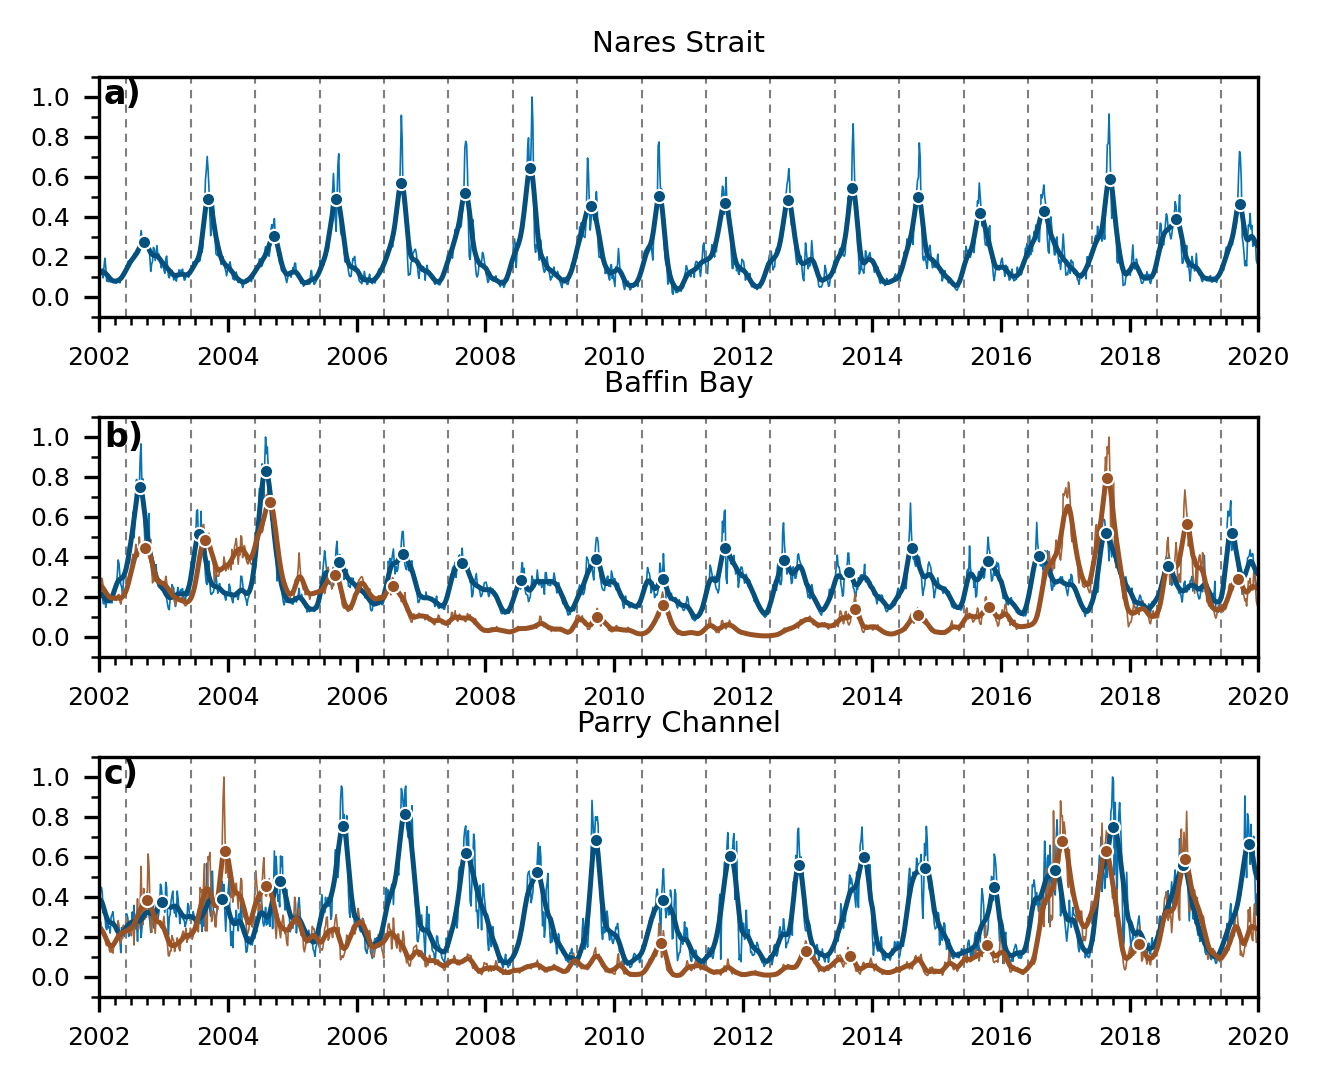

In [24]:
fig, ax = plt.subplots(3,1, figsize=(4.5,3.7), dpi=300)

for axis in ax.ravel():
    axis.tick_params(axis='both', which='major', labelsize=6)
    axis.set_xlim(dt.datetime(2002,1,1),dt.datetime(2020,1,1))
    axis.yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
    axis.yaxis.set_major_locator(MultipleLocator(0.2));
    axis.yaxis.set_minor_locator(MultipleLocator(0.1));
    axis.xaxis.set_minor_locator(mdates.MonthLocator(bymonth=(1,4,7,10)))
    axis.set_ylim(-0.1,1.1)
    
    for i in cn_i:
        axis.axvline(months[i], color='#7f7f7f', linewidth=0.5, zorder=2, linestyle='--', dashes=(4, 3))
    
# Nares Strait
ax[0].set_title('Nares Strait', fontsize=7)
ax[0].plot(dates, N1_gc_smooth, color=color_glac_dark, zorder=2, linewidth=1.2)
ax[0].plot(dates, norm_N1_gc, color=color_glac, zorder=1, linewidth=0.4)
ax[0].scatter([dates[int(t)] for t in time_lag_N1_gc_date if ~np.isnan(t)], \
              [N1_gc_smooth[int(t)] for t in time_lag_N1_gc_date if ~np.isnan(t)], \
              color=color_glac_dark, zorder=3, s=10, edgecolor='w', linewidth=0.5)
    
# Baffin Bay
ax[1].set_title('Baffin Bay', fontsize=7)
ax[1].plot(dates, BB_gc_smooth   , color=color_glac_dark, zorder=2, linewidth=1.2)
ax[1].plot(dates, norm_BB_gc     , color=color_glac, zorder=1, linewidth=0.4)
ax[1].scatter([dates[int(t)] for t in time_lag_BB_gc_date if ~np.isnan(t)], \
              [BB_gc_smooth[int(t)] for t in time_lag_BB_gc_date if ~np.isnan(t)], \
              color=color_glac_dark, zorder=3, s=10, edgecolor='w', linewidth=0.5)
ax[1].plot(dates, BB_cn_smooth, color=color_cont_dark, zorder=2, linewidth=1.2)
ax[1].plot(dates, norm_BB_cn  , color=color_cont, zorder=1, linewidth=0.4)
ax[1].scatter([dates[int(t)] for t in time_lag_BB_cn_date if ~np.isnan(t)], \
              [BB_cn_smooth[int(t)] for t in time_lag_BB_cn_date if ~np.isnan(t)], \
              color=color_cont_dark, zorder=3, s=10, edgecolor='w', linewidth=0.5)

# Parry Channel
ax[2].set_title('Parry Channel', fontsize=7)
ax[2].plot(dates, PC_gc_smooth, color=color_glac_dark, zorder=2, linewidth=1.2)
ax[2].plot(dates, norm_PC_gc, color=color_glac, zorder=1, linewidth=0.4)
ax[2].scatter([dates[int(t)] for t in time_lag_PC_gc_date if ~np.isnan(t)], \
              [PC_gc_smooth[int(t)] for t in time_lag_PC_gc_date if ~np.isnan(t)], \
              color=color_glac_dark, zorder=3, s=10, edgecolor='w', linewidth=0.5)
ax[2].plot(dates, PC_cn_smooth, color=color_cont_dark, zorder=2, linewidth=1.2)
ax[2].plot(dates, norm_PC_cn, color=color_cont, zorder=1, linewidth=0.4)
ax[2].scatter([dates[int(t)] for t in time_lag_PC_cn_date if ~np.isnan(t)], \
              [PC_cn_smooth[int(t)] for t in time_lag_PC_cn_date if ~np.isnan(t)], \
              color=color_cont_dark, zorder=3, s=10, edgecolor='w', linewidth=0.5)

#------------------------------------------------------------
plt.tight_layout(w_pad=0, h_pad=0)

# add text labels:
fig.text(0.088, 0.893, 'a)', fontsize=8, weight='bold');
fig.text(0.088, 0.584, 'b)', fontsize=8, weight='bold');
fig.text(0.088, 0.280, 'c)', fontsize=8, weight='bold');

# fig.text(0.569, 0.895, 'd)', fontsize=8, weight='bold');
# fig.text(0.569, 0.593, 'e)', fontsize=8, weight='bold');
# fig.text(0.569, 0.295, 'f)', fontsize=8, weight='bold');

# fig.savefig('/ocean/brogalla/GEOTRACES/figures/rivers-paper-202206/S10a-time_lag.jpg', bbox_inches='tight', dpi=300)/ocean/brogalla/GEOTRACES/figures/rivers-paper-202206/

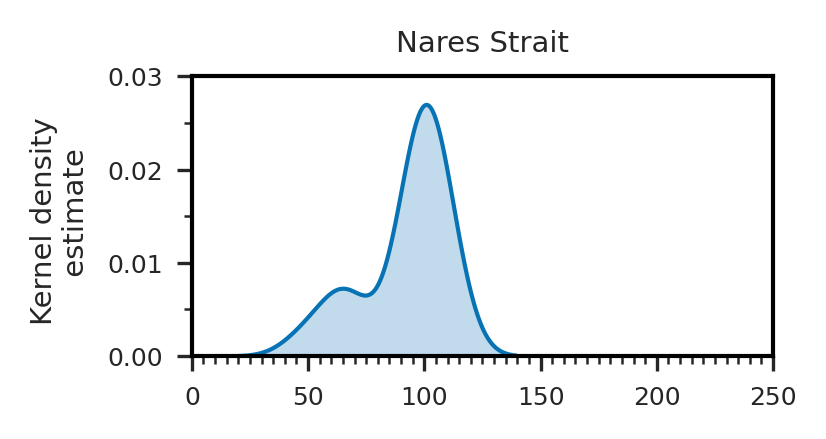

In [25]:
st = sns.axes_style("ticks")

with st:
    fig = plt.figure(figsize=(2.5,3.7/3), dpi=300)
    ax  = sns.kdeplot(time_lag_N1_gc, shade=True, color=color_glac, label='Glacial')    
    ax.set(ylim=(0, 0.03), xlim=(0,250))
    ax.tick_params(axis='both', which='major', labelsize=6)
    ax.spines['left'].set_linewidth(1.0);   ax.spines['left'].set_color('black');
    ax.spines['bottom'].set_linewidth(1.0); ax.spines['bottom'].set_color('black');
    ax.spines['right'].set_linewidth(1.0);  ax.spines['right'].set_color('black');
    ax.spines['top'].set_linewidth(1.0);    ax.spines['top'].set_color('black');
    
    ax.set_ylabel('Kernel density \n estimate', fontsize=7)
    ax.set_title('Nares Strait', fontsize=7)
    
    ax.yaxis.set_major_locator(MultipleLocator(0.01));
    ax.yaxis.set_minor_locator(MultipleLocator(0.005));
    ax.xaxis.set_major_locator(MultipleLocator(50));
    ax.xaxis.set_minor_locator(MultipleLocator(5));
    
# fig.savefig('/ocean/brogalla/GEOTRACES/figures/rivers/S10b-time-lag-NS.png', bbox_inches='tight', dpi=300)

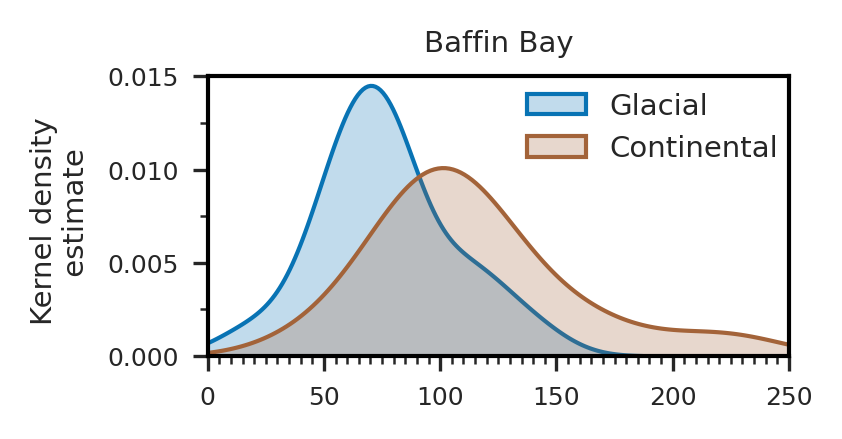

In [26]:
st = sns.axes_style("ticks")

with st:
    fig = plt.figure(figsize=(2.5,3.7/3), dpi=300)
    ax = sns.kdeplot(time_lag_BB_gc, shade=True, color=color_glac, label='Glacial')
    sns.kdeplot(time_lag_BB_cn, shade=True, color=color_cont, label='Continental')

    ax.set(ylim=(0, 0.015), xlim=(0,250))
    ax.tick_params(axis='both', which='major', labelsize=6)
    ax.spines['left'].set_linewidth(1.0);   ax.spines['left'].set_color('black');
    ax.spines['bottom'].set_linewidth(1.0); ax.spines['bottom'].set_color('black');
    ax.spines['right'].set_linewidth(1.0);  ax.spines['right'].set_color('black');
    ax.spines['top'].set_linewidth(1.0);    ax.spines['top'].set_color('black');

    ax.set_ylabel('Kernel density \n estimate', fontsize=7)
    ax.set_title('Baffin Bay', fontsize=7)
    
    ax.legend(loc=(0.53, 0.65), fontsize=7, frameon=False)    
    ax.yaxis.set_major_locator(MultipleLocator(0.005));
    ax.yaxis.set_minor_locator(MultipleLocator(0.0025));
    ax.xaxis.set_major_locator(MultipleLocator(50));
    ax.xaxis.set_minor_locator(MultipleLocator(5));

# fig.savefig('/ocean/brogalla/GEOTRACES/figures/rivers/S10b-time-lag-BB.png', bbox_inches='tight', dpi=300)

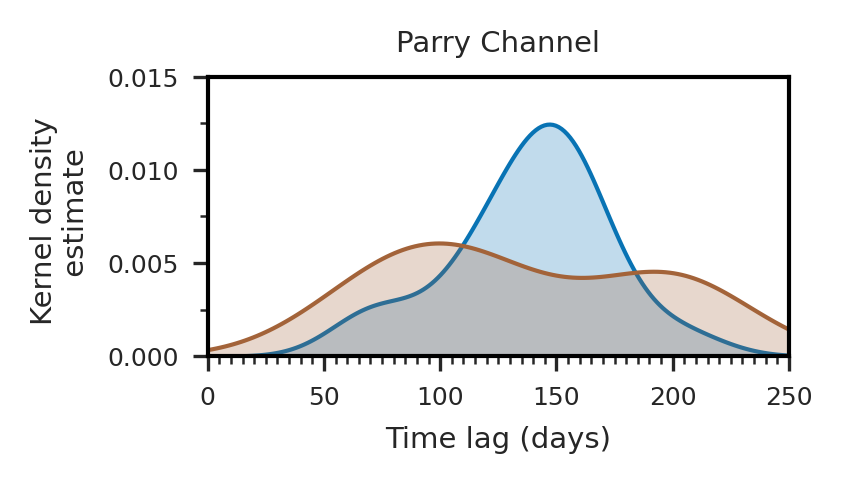

In [27]:
st = sns.axes_style("ticks")

with st:
    fig = plt.figure(figsize=(2.5,3.7/3), dpi=300)
    ax = sns.kdeplot(time_lag_PC_gc, shade=True, color=color_glac, label='Glacial')
    sns.kdeplot(time_lag_PC_cn, shade=True, color=color_cont, label='Continental')
    
    ax.set(ylim=(0, 0.015), xlim=(0,250))
    ax.tick_params(axis='both', which='major', labelsize=6)
    ax.spines['left'].set_linewidth(1.0);   ax.spines['left'].set_color('black');
    ax.spines['bottom'].set_linewidth(1.0); ax.spines['bottom'].set_color('black');
    ax.spines['right'].set_linewidth(1.0);  ax.spines['right'].set_color('black');
    ax.spines['top'].set_linewidth(1.0);    ax.spines['top'].set_color('black');

    ax.set_xlabel('Time lag (days)', fontsize=7)
    ax.set_ylabel('Kernel density \n estimate', fontsize=7)
    ax.set_title('Parry Channel', fontsize=7)    
    
    ax.yaxis.set_major_locator(MultipleLocator(0.005));
    ax.yaxis.set_minor_locator(MultipleLocator(0.0025));
    ax.xaxis.set_major_locator(MultipleLocator(50));
    ax.xaxis.set_minor_locator(MultipleLocator(5));
    
#     ax.legend(loc=(0.53, 0.65), fontsize=7, frameon=False)
    
# fig.savefig('/ocean/brogalla/GEOTRACES/figures/rivers/S10b-time-lag-PC.png', bbox_inches='tight', dpi=300)